1. Imports

In [1]:
# may be needed to install some libraries such as tensorflow and keras
# %pip install tensorflow

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, random
import CustomFunctions # custom our functions
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization, Activation,GlobalAveragePooling2D,Input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras import layers
import cv2

2. Data import

In [1]:
train_dir = "../../Data/AAUT2IA/train" #passing the path with training images
test_dir = "../../Data/AAUT2IA/test"   #passing the path with testing images

img_size = 48 #original size of the image

Our dataset contains 28709 *train* images and 7178 *test* images.

The goal of this dataset is to identify sentiment based on a person face in order to (Melhorar não sei o que em recursos humanos)

That said the dataset contains images of people faces and 7 "class" of sentiments are available

* Angry
* Disgust
* Fear
* Happy 
* Neutral
* Sad
* Surprise

In [3]:
Emotions, train_dir_file_count = CustomFunctions.dirInfo(train_dir)

print("This dataset contains on \"" + train_dir + "\" " , train_dir_file_count, " in total")
print(Emotions, "\n\n")

_, test_dir_file_count = CustomFunctions.dirInfo(test_dir)

print("This dataset contains on \"" + test_dir + "\" " , test_dir_file_count, " in total")
print(_)

This dataset contains on "../../Data/AAUT2IA/train"  28709  in total
{'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171} 


This dataset contains on "../../Data/AAUT2IA/test"  7178  in total
{'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


*** ANGRY
  * Contains 3995  images


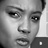

*** DISGUST
  * Contains 436  images


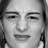

*** FEAR
  * Contains 4097  images


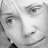

*** HAPPY
  * Contains 7215  images


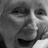

*** NEUTRAL
  * Contains 4965  images


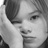

*** SAD
  * Contains 4830  images


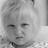

*** SURPRISE
  * Contains 3171  images


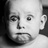

In [4]:
for emotion in Emotions:
    # class path - path to train dir + class name
    classPath   = train_dir + '/' + emotion

    # gets a random Image from each directory
    randomImage = random.choice(os.listdir(classPath))

    # prints Image Info
    print("*** " + emotion.upper())
    print("  * Contains", Emotions[emotion], " images")
    CustomFunctions.printImage(classPath, randomImage)

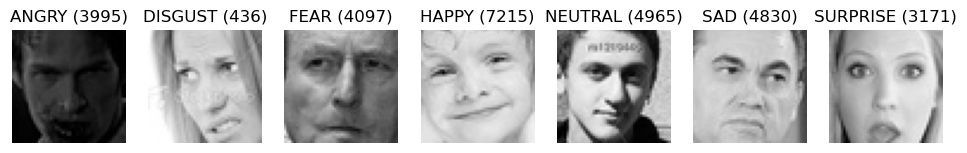

In [5]:
# setting values to rows and column variables
rows = 1
columns = 7
i = 1

# create figure
fig = plt.figure(figsize=(12, 9))


for emotion in Emotions:
    # class path - path to train dir + class name
    classPath   = train_dir + '/' + emotion
    
    # gets a random Image from each directory
    randomImage = random.choice(os.listdir(classPath))

    # Adds a subplot at the n position
    fig.add_subplot(rows, columns, i)
    # showing image
    plt.imshow(cv2.imread(classPath + '/' + randomImage))
    plt.axis('off')
    plt.title(emotion.upper() + " (" + str(Emotions[emotion]) + ")")

    i += 1


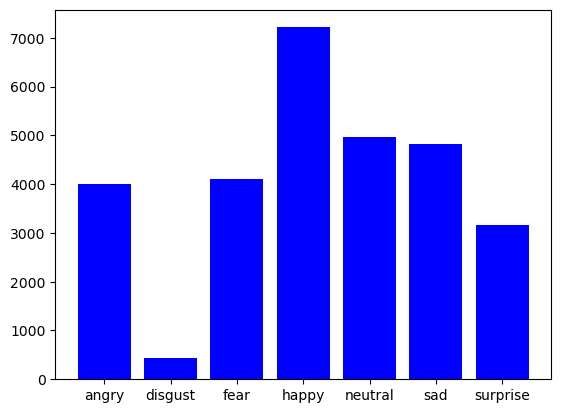

In [44]:
# create distribution plot about the number of images per class

for (emotion, count) in Emotions.items():
    plt.bar(emotion, count, color='blue')

(-1.1125279522049465,
 1.1169040515158202,
 -1.1082469107516235,
 1.1003927100357915)

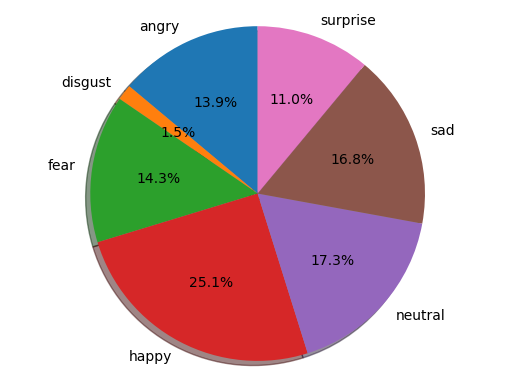

In [51]:
# create pie plot about the number of images per class
plt.pie(Emotions.values(), labels=Emotions.keys(), autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

* There´s clearly a some inbalance in our dataset as disgust images only represent 1.5% of the total dataset images, lets try to improve by using data augmentation

In [72]:
Avg = 100 / Emotions.__len__()
Avg_qtd = int((Avg * train_dir_file_count/100))

# print the difference beetween the average and the number of images per class
for (emotion, count) in Emotions.items():
    print ("Emotion: " + emotion + " - [" + str(count) + "] images - [" + str(Avg_qtd - count) + "] images to reach the average")


Emotion: angry - [3995] images - [106] images to reach the average
Emotion: disgust - [436] images - [3665] images to reach the average
Emotion: fear - [4097] images - [4] images to reach the average
Emotion: happy - [7215] images - [-3114] images to reach the average
Emotion: neutral - [4965] images - [-864] images to reach the average
Emotion: sad - [4830] images - [-729] images to reach the average
Emotion: surprise - [3171] images - [930] images to reach the average


* Data Augmentation

*ImageDataGenerator*

* rotation_range = rotates the image with the amount of degrees we provide
* width_shift_range = shifts the image randomly to the right or left along the width of the image
* height_shift range = shifts image randomly to up or below along the height of the image
* horizontal_flip = flips the image horizontally
* rescale = to scale down the pizel values in our image between 0 and 1
* zoom_range = applies random zoom to our object
* validation_split = reserves some images to be used for validation purpose


In [126]:
# data augmentation - to increase the number of images

train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

Applying data augmentation to the images as we read 
them from their respective directories

In [127]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 28709 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [ ]:
IMG_SIZE = 320  # All images will be resized to 160x160

# create more images to balance the dataset using data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.3),
  layers.RandomZoom(0.2),
])

for emotion in Emotions:
    # class path - path to train dir + class name
    classPath   = train_dir + '/' + emotion
    
    # gets a random Image from each directory
    randomImage = random.choice(os.listdir(classPath))

    # convert image to numpy array
    img = keras.preprocessing.image.image_utils.img_to_array(
        keras.preprocessing.image.image_utils.load_img(classPath + '/' + randomImage, target_size=(IMG_SIZE, IMG_SIZE))
    )

    plt.imshow(cv2.imread(classPath + '/' + randomImage))
    plt.axis('off')
    plt.title("Original Image")
    plt.show()

    for i in range(3):
      augmented_image = data_augmentation(img)
      ax = plt.subplot(1, 3, i + 1)
      plt.imshow(augmented_image.numpy()/255)
      plt.axis("off")
    break

* Model 1 - CNN

In [147]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [148]:
epochs = 150
batch_size = 128
model.summary()

# fit the model
history = model.fit(x = train_generator, epochs = 20, validation_data = validation_generator)

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 128)     

KeyboardInterrupt: 

# Data Augmentation

In [74]:
"""
Data Augmentation
--------------------------
rotation_range = rotates the image with the amount of degrees we provide
width_shift_range = shifts the image randomly to the right or left along the width of the image
height_shift range = shifts image randomly to up or below along the height of the image
horizontal_flip = flips the image horizontally
rescale = to scale down the pizel values in our image between 0 and 1
zoom_range = applies random zoom to our object
validation_split = reserves some images to be used for validation purpose
"""

train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [75]:
"""
Applying data augmentation to the images as we read 
them from their respectivve directories
"""
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


# Model  

In [9]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

d:\Conda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
epochs = 150
batch_size = 128
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [11]:
history = model.fit(x = train_generator,epochs = 20,validation_data = validation_generator)

Epoch 1/20
  3/359 [..............................] - ETA: 9:21 - loss: 10.3363 - accuracy: 0.1458

KeyboardInterrupt: 

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()